In [ ]:
!pip install mne
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import mne
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import scipy.io
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sb

In [ ]:
sub=['MM05', 'MM08','MM09','MM10','MM11','MM12','MM14','MM15','MM16','MM18',
     'MM19','MM20','MM21','P02']

EEGFiles=['Acquisition 232 Data', 'Acquisition 261 Data', 'Acquisition 263 Data',
          'Acquisition 284 Data', 'Acquisition 283 Data', 'Acquisition 283 Data',
           'Acquisition 283 Data', 'Acquisition 283 Data', 'Acquisition 283 Data',
          'Acquisition 283 Data', 'Acquisition 283 Data', 'Acquisition 283 Data',
          'Acquisition 01 Data', 'EEG_SPEECH_TEST_20140530']

tagFiles=['MM05_p', 'MM08_p','MM09_p','MM10_p','MM11_p','MM12_p','MM14_p','MM15_p',
          'MM16_p','MM18_p','MM19_p','MM20_p','MM21_p','P02_p']

EEGPath='/content/drive/My Drive/p/spoclab/users/szhao/EEG/data/'
tagsPath='/content/drive/My Drive/p/spoclab/users/szhao/EEG/data/'
epochsPath='/content/drive/My Drive/p/spoclab/users/szhao/EEG/data/'

EEGChannels= ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2',
       'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6',
       'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3',
       'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2',
       'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ',
        'O2', 'CB1', 'CB2']

In [ ]:
def getEEGdata(index):
    fileName= EEGPath+sub[index]+'/'+EEGFiles[index]+'.cnt'
    #import raw EEG file
    rawEEG = mne.io.read_raw_cnt(fileName, preload=True)
    #Plotting raw EEG data for 10 channels
    #rawEEG.plot(duration=5, n_channels=10, title="Raw EEG data plot")
    #Selecting only EEG channels (excluding EMG channels)
    rawEEG= rawEEG.pick_channels(EEGChannels)
    #Applying band-pass filtering from 1Hz to 50Hz
    rawEEG.filter(1., 50.,fir_design='firwin')
    #Plotting filtered EEG data for 10 channels
    #rawEEG.plot(duration=5, n_channels=10, title="Filtered EEG data plot")
    #obtaining data and time indexes
    data, times = rawEEG[:]
    return data, times

In [ ]:
def getTags(index):
    fileName= tagsPath+ sub[index]+'/kinect_data/'+ tagFiles[index]+'.txt'
    tags = np.loadtxt(fileName, dtype=str)
    tags = np.delete(tags, np.argwhere(tags == 'gnaw'))
    tags = np.delete(tags, np.argwhere(tags == 'knew'))
    tags = np.delete(tags, np.argwhere(tags == 'pat'))
    tags = np.delete(tags, np.argwhere(tags == 'pot'))
    tags = np.delete(tags, np.argwhere(tags == '/tiy/'))
    tags = np.delete(tags, np.argwhere(tags == '/diy/'))
    tags = np.delete(tags, np.argwhere(tags == '/piy/'))
    end = np.shape(tags)[0]
    tags[(tags == '/uw/') ] = 0
    tags[(tags == '/iy/') ] = 0
    #tags[(tags == '/tiy/') ] = 1
    #tags[(tags == '/diy/') ] = 1
    #tags[(tags == '/piy/') ] = 1
    tags[(tags == '/m/') ] = 1
    tags[(tags == '/n/') ] = 1
    y = tags.astype(float)
    class_0 = sum(y==0)
    class_1 = sum(y==1)
    print("Printing trials info for sub ", index+1)
    print("+-----------------------------------------------------+")
    print("Number of class 0: ", class_0)
    print("Number of class 1: ", class_1)
    proportion_0= class_0/len(y)
    proportion_1= class_1/len(y)
    print("Proportion of class 0: ", proportion_0)
    print("Proportion of class 1: ", proportion_1)
    print("+-----------------------------------------------------+")
    return y, end

In [ ]:
def getEpochingIndexes(index, end):
    fileName= epochsPath+sub[index]+'/epoch_inds.mat'
    epochIndicesData = scipy.io.loadmat(fileName)
    epochIndicesArray = epochIndicesData.get('clearing_inds')
    epochIndices = epochIndicesArray[:, :end]
    #print(np.shape(epochIndices))
    maxdiff = 0
    for i in range(end):
        temp = epochIndices[0,i]
        start = temp[0,0]
        ending = temp [0,1]
        diff = ending - start
        if diff> maxdiff:
            maxdiff = diff
    return epochIndices, maxdiff

In [ ]:
def getEpochedCCVData(data, epochIndices, maxdiff):
    epochedCCV = []
    for i in range(np.shape(epochIndices)[1]):
        temp = epochIndices[0,i]
        start = temp[0,0]
        ending = temp [0,1]
        trial= data[:, start:start+maxdiff]
        CCV = np.cov(trial, bias=True)
        epochedCCV.append(CCV)
    X = np.array(epochedCCV)
    return X

In [ ]:
def get_X_y_sub(index):
    data, times = getEEGdata(index)
    y, end= getTags(index)
    epochIndices, maxdiff= getEpochingIndexes(index, end)
    X= getEpochedCCVData(data, epochIndices, maxdiff)
    return X, y

In [ ]:
X,y = get_X_y_sub(0)
#for i in range(1,14):
for i in range(1,3):
    X_sub, y_sub = get_X_y_sub(i)
    X = np.concatenate((X, X_sub), axis=0)
    y = np.concatenate((y, y_sub), axis=0)

Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...


KeyboardInterrupt: ignored

In [ ]:
print(np.shape(X))

(155, 62, 62)


1232 = trials

62 = channels

(1232 x 62 x 62) => Channel Cross Covariance Matrix for 62 channels for a total of 1232 trials

In [ ]:
print(np.shape(y))

(155,)


1232 = trials

(1232, ) => Tags for 1232 trials

In [ ]:
class_0 = sum(y==0)
class_1 = sum(y==1)
proportion_0= class_0/len(y)
proportion_1= class_1/len(y)

print("Printing trials info for entire datatset")
print("+-----------------------------------------------------+")
print("Number of class 0: ", class_0)
print("Number of class 1: ", class_1)
print("Proportion of class 0: ", proportion_0)
print("Proportion of class 1: ", proportion_1)
print("+-----------------------------------------------------+")

Printing trials info for entire datatset
+-----------------------------------------------------+
Number of class 0:  77
Number of class 1:  78
Proportion of class 0:  0.4967741935483871
Proportion of class 1:  0.5032258064516129
+-----------------------------------------------------+


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = torch.LongTensor(targets)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

# NETWORK ARCHITECTURE

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.drop1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.drop2 = nn.Dropout(0.50)
        self.fc1 = nn.Linear(64*58*58, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x_out = F.relu(self.fc1(x))
        x = self.fc2(x_out)
        return x, x_out

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=62*62, hidden_size=128, num_layers=1,
                             batch_first=True, dropout=0.25)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1,
                             batch_first=True, dropout=0.50)
        self.fc1 = nn.Linear(256, 1024)   #what about 512?
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x, hidden = self.lstm1(x)
        x = F.relu(x)
        x, hidden = self.lstm2(x)
        x = F.relu(x)
        #x = x.view(x.size(0), -1)
        x_out = F.relu(self.fc1(x))
        x = self.fc2(x_out)
        return x, x_out

In [ ]:
class DAE(nn.Module):
  def __init__(self):
    super(DAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(1152, 512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(128, 32),
        nn.Sigmoid(),
        nn.Dropout(0.25)
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 128),
        nn.Sigmoid(),
        nn.Dropout(0.25),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, 1152),
        nn.Tanh(),
        nn.Dropout(0.25)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
def trainCNN(epoch, training_loader):
    predicted_labels = []
    modelCNN.train()
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        train_X, train_y = data
        train_X = train_X.reshape(train_X.shape[0], 1, 62, 62)
        train_X = train_X.float()
        train_y = train_y.long()

        # getting the training set
        X_train, y_train = Variable(train_X), Variable(train_y)
        # converting the data into GPU format
        if torch.cuda.is_available():
            X_train = X_train.cuda()
            y_train = y_train.cuda()

        # clearing the Gradients of the model parameters
        optimizerCNN.zero_grad()

        # prediction for training and test set
        output_train, CNN_out_train = modelCNN(X_train)

        # computing the training loss
        loss_train = criterion(output_train, y_train)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizerCNN.step()

    #if epoch%2 == 0:
        #print('Epoch : ',epoch+1, ' loss :', loss_test, ' accuracy :', test_accuracy)
    return modelCNN
    #return accuracy, cm, f1, CNN_out_train, CNN_out_test

In [ ]:
def trainLSTM(epoch, training_loader):
    predicted_labels = []
    modelLSTM.train()
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        train_X, train_y = data
        train_X = train_X.reshape([train_X.shape[0], 1, 62*62])
        train_X = train_X.float()
        train_y = train_y.long()
        # getting the training set
        X_train, y_train = Variable(train_X), Variable(train_y)
        # converting the data into GPU format
        if torch.cuda.is_available():
            X_train = X_train.cuda()
            y_train = y_train.cuda()

        # clearing the Gradients of the model parameters
        optimizerLSTM.zero_grad()

        # prediction for training and test set
        output_train, LSTM_out_train = modelLSTM(X_train)
        output_train = torch.reshape(output_train, (output_train.shape[0],2))

        # computing the training loss
        loss_train = criterion(output_train, y_train)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizerLSTM.step()

    #if epoch%2 == 0:
        #print('Epoch : ',epoch+1, ' loss :', loss_test, ' accuracy :', test_accuracy)
    return modelLSTM
    #return accuracy, cm, f1, LSTM_out_train, LSTM_out_test

In [ ]:
def trainDAE(epoch):
  # getting the training set
  train_DAE = Variable(DAE_train)
  # getting the test set
  test_DAE = Variable(DAE_test)
  # converting the data into GPU format
  if torch.cuda.is_available():
    train_DAE = train_DAE.cuda()
    test_DAE = test_DAE.cuda()

  # clearing the Gradients of the model parameters
  optimizerDAE.zero_grad()

  # getting the reconstructed train, test values after putting into the DAE
  reconstructed_train = modelDAE(train_DAE)
  reconstructed_test = modelDAE(test_DAE)

  # computing training and testing loss
  loss_train = criterion_DAE(reconstructed_train, train_DAE)
  loss_test = criterion_DAE(reconstructed_test, test_DAE)

  # computing the updated weights of all the model parameters
  loss_train.backward()
  optimizerDAE.step()

  #if epoch%2 == 0:
    #print('Epoch : ',epoch+1, ' loss :', loss_test)

  return loss_train, loss_test, reconstructed_train, reconstructed_test

In [ ]:
def trainXGB():
  train = xgb.DMatrix(XGB_train_X, label= XGB_train_y)
  test = xgb.DMatrix(XGB_test_X, label= XGB_test_y)
  param = {
      'booster': 'gbtree',
      'max_depth': 10,
      'n_estimators': 5000,
      'learning_rate': 0.1,
      #'reg_alpha': 0.3,
      #'reg_lambda': 0.3,
      'subsample': 0.8,
      #'colsample_bytree': 0.4, #by tree
      'colsample_bylevel': 0.4, #by level
      #'colsample_bynode': 0.4, #by node
      'objective': 'multi:softmax',
      'num_class': 2
      }
  epochs = 50
  model = xgb.train(param, train, epochs)
  predictions_train = model.predict(train)
  predictions_test = model.predict(test)
  accuracy_train = sum(predictions_train==XGB_train_y)/len(XGB_train_y)
  accuracy_test = sum(predictions_test==XGB_test_y)/len(XGB_test_y)

  #computing confusion matrix and F1 score
  cm = confusion_matrix(XGB_test_y, predictions_test)
  f1 = f1_score(XGB_test_y, predictions_test)

  #calculating average loss for batch
  print("XGB")
  print("output size: ", predictions_train.shape)
  print("For training:")
  print("Batch accuracy: ", accuracy_train)
  print("For testing:")
  print("Batch accuracy: ", accuracy_test)
  return predictions_train, predictions_test, accuracy_test, cm, f1

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

# Hyper-parameters
#num_epochs = 50
num_epochs = 40
num_epochs_DAE = 200
batch_size = 64
learning_rate = 0.001

#instantiating the model
modelCNN = ConvNet().to(device)
modelLSTM = LSTM().to(device)
modelDAE = DAE().to(device)

#setting model loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion_DAE = nn.MSELoss()
optimizerCNN = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
optimizerLSTM = torch.optim.Adam(modelLSTM.parameters(), lr=learning_rate)
optimizerDAE = torch.optim.Adam(modelDAE.parameters(), lr=learning_rate)

print(modelCNN)
print(modelLSTM)
print(modelDAE)

cuda
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm1): LSTM(3844, 128, batch_first=True, dropout=0.25)
  (lstm2): LSTM(128, 256, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)
DAE(
  (encoder): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.25, inplace=False)
  )
  (decoder): Seq

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def model_fit_CNN(training_loader, train_X, test_X, test_y):

    # training the model
    for epoch in range(num_epochs):
        modelCNN = trainCNN(epoch, training_loader)

    modelCNN.eval()

    #  getting inputs ready to get the final train and test outputs from trained model
    X_train, X_test, y_test = Variable(train_X), Variable(test_X), Variable(test_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        X_test = X_test.cuda()
        y_test = y_test.cuda()
    output_train, CNN_out_train = modelCNN(X_train)
    output_test, CNN_out_test = modelCNN(X_test)
    #Performance metrics

    predicted_labels_test = torch.argmax(output_test, dim=1)
    accuracy = sum(predicted_labels_test==y_test)/len(y_test)
    predicted_labels_test = predicted_labels_test.cpu().detach().numpy()
    y_test = y_test.cpu().detach().numpy()
    cm = confusion_matrix(y_test, predicted_labels_test)
    f1 = f1_score(y_test, predicted_labels_test)


    return accuracy, cm, f1, CNN_out_train, CNN_out_test

In [ ]:
def model_fit_LSTM(training_loader, train_X, test_X, test_y):

    # training the model
    for epoch in range(num_epochs):
        modelLSTM = trainLSTM(epoch, training_loader)

    modelLSTM.eval()

    #  getting inputs ready to get the final train and test outputs from trained model
    X_train, X_test, y_test = Variable(train_X), Variable(test_X), Variable(test_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        X_test = X_test.cuda()
        y_test = y_test.cuda()
    output_train, LSTM_out_train = modelLSTM(X_train)
    output_test, LSTM_out_test = modelLSTM(X_test)
    #Performance metrics

    #y_test = y_test.reshape(y_test.shape[0],2)
    predicted_labels_test = torch.argmax(output_test, dim=1)
    accuracy = sum(predicted_labels_test==y_test)/len(y_test)
    predicted_labels_test = predicted_labels_test.cpu().detach().numpy()
    y_test = y_test.cpu().detach().numpy()
    cm = confusion_matrix(y_test, predicted_labels_test)
    f1 = f1_score(y_test, predicted_labels_test)

    return accuracy, cm, f1, LSTM_out_train, LSTM_out_test

In [ ]:
def model_fit_DAE():
  # empty list to store training and test losses
  train_losses, test_losses = [], []
  # empty list to store training and test DAE_out
  train_DAE_out, test_DAE_out = [], []

  # training the model
  for epoch in range(num_epochs_DAE):
    train_loss, test_loss, trainDAE_out, testDAE_out = trainDAE(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_DAE_out.append(trainDAE_out)
    test_DAE_out.append(testDAE_out)

  #calculating average loss for batch
  batch_train_loss, batch_test_loss = sum(train_losses)/len(train_losses), sum(test_losses)/len(test_losses)
  print("DAE")
  print("output size: ", train_DAE_out[0].shape)
  print("For training:")
  print("Batch loss: ", batch_train_loss)
  print("For testing:")
  print("Batch loss: ", batch_test_loss)
  return batch_train_loss, batch_test_loss, train_DAE_out[-1], test_DAE_out[-1]
  # which epoch's LSTM out to return for that batch?

CNN CONFUSION MATRIX
[[8 0]
 [8 0]]


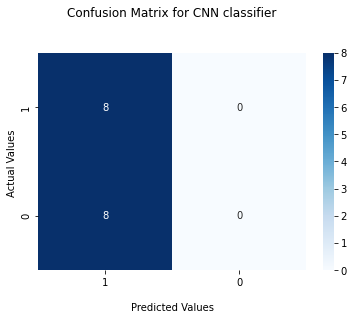

CNN F1 Score:  0.0


RuntimeError: ignored

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

#list to store test accuracy for each split
CNN_accuracy1=[]
LSTM_accuracy1=[]
DAE_loss1=[]
XGB_accuracy1=[]

for train_index, test_index in skf.split(X,y):
    torch.cuda.empty_cache()
    #print("train index size: ", train_index.size)
    #print("test index size: ", test_index.size)
    #print("TRAIN INDICES: ", train_index, "TEST INDICES: ", test_index)

    #getting data split into test and train
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #weighted random sampler to remove imbalance in  mini batch
    #print('y train tags 0/1: {}/{}'.format(len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))
    class_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weight = 1. / class_count
    samples_weight=[]
    for t in y_train:
        if t==0:
            samples_weight.append(weight[0])
        else:
            samples_weight.append(weight[1])
    samples_weight = np.array(samples_weight)
    samples_weight=torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    #creating a custom torch Dataset with training array
    #using dataloader for train data

    training_data = MyDataset(X_train, y_train)
    training_dataloader = DataLoader(training_data, batch_size=64, sampler=sampler)

    #getting dataloader inputs ready for CNN network

    train_X_CNN = X_train.reshape(X_train.shape[0], 1, 62, 62)
    test_X_CNN = X_test.reshape(X_test.shape[0], 1, 62, 62)
    train_X_CNN = torch.from_numpy(train_X_CNN)
    train_X_CNN = train_X_CNN.float()
    test_X_CNN = torch.from_numpy(test_X_CNN)
    test_X_CNN = test_X_CNN.float()
    train_y = torch.from_numpy(y_train).long()
    test_y = torch.from_numpy(y_test).long()
    #print("class 0 train: ", sum(train_y==0)/len(train_y), "class 1 train: ", sum(train_y==1)/len(train_y))
    #print("class 0 test: ", sum(test_y==0)/len(test_y), "class 1 test: ", sum(test_y==1)/len(test_y))
    CNN_accuracy, CNN_cm, CNN_f1, CNN_train_out, CNN_test_out = model_fit_CNN(training_dataloader, train_X_CNN,  test_X_CNN,  test_y)
    CNN_accuracy1.append(CNN_accuracy)
    print("CNN CONFUSION MATRIX")
    print(CNN_cm)
    ax = sb.heatmap(CNN_cm, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix for CNN classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['1','0'])
    ax.yaxis.set_ticklabels(['1','0'])
    plt.show()
    print("CNN F1 Score: ", CNN_f1)

    '''#getting dataloader inputs ready for LSTM network
    train_X_LSTM = X_train.reshape([X_train.shape[0], 1, 62*62])
    test_X_LSTM = X_test.reshape([X_test.shape[0], 1, 62*62])
    train_X_LSTM = torch.from_numpy(train_X_LSTM)
    train_X_LSTM = train_X_LSTM.float()
    test_X_LSTM = torch.from_numpy(test_X_LSTM)
    test_X_LSTM = test_X_LSTM.float()
    train_y = torch.from_numpy(y_train).long()
    test_y = torch.from_numpy(y_test).long()
    LSTM_accuracy, LSTM_cm, LSTM_f1, LSTM_train_out, LSTM_test_out = model_fit_LSTM(training_dataloader, train_X_LSTM, test_X_LSTM, test_y)
    LSTM_accuracy1.append(LSTM_accuracy)
    print("LSTM CONFUSION MATRIX")
    print(LSTM_cm)
    ax = sb.heatmap(LSTM_cm, annot=True, cmap='Reds')
    ax.set_title('Confusion Matrix for LSTM classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['1','0'])
    ax.yaxis.set_ticklabels(['1','0'])
    plt.show()
    print("LSTM F1 Score: ", LSTM_f1)

    #getting inputs ready for the DAE
    LSTM_train_out_reshaped = LSTM_train_out.reshape(LSTM_train_out.shape[0], LSTM_train_out.shape[2])
    LSTM_test_out_reshaped = LSTM_test_out.reshape(LSTM_test_out.shape[0], LSTM_test_out.shape[2])
    DAE_train = torch.cat((CNN_train_out, LSTM_train_out_reshaped), 1)
    DAE_test = torch.cat((CNN_test_out, LSTM_test_out_reshaped), 1)
    DAE_batch_loss_train, DAE_batch_loss_test, DAE_train_out, DAE_test_out = model_fit_DAE()
    DAE_loss1.append(DAE_batch_loss_test)

    #getting inputs ready for the XGBoost layer
    XGB_train_X = DAE_train_out.cpu().detach().numpy()
    XGB_train_y = train_y.cpu().detach().numpy()
    XGB_test_X = DAE_test_out.cpu().detach().numpy()
    XGB_test_y = test_y.cpu().detach().numpy()
    XGB_train_out, XGB_test_out, XGB_batch_accuracy, XGB_batch_cm, XGB_batch_f1 = trainXGB()
    XGB_accuracy1.append(XGB_batch_accuracy)
    print("OVERALL CONFUSION MATRIX")
    print(XGB_batch_cm)
    ax = sb.heatmap(XGB_batch_cm, annot=True, cmap='Greens')
    ax.set_title('Confusion Matrix for Overall classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show()
    print("OVERALL F1 Score: ", XGB_batch_f1)'''

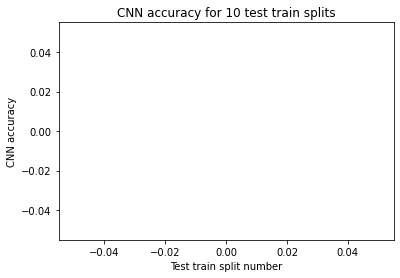

ValueError: ignored

In [ ]:
#Plotting CNN accuracy
x = np.arange(1, len(CNN_accuracy1)+1)
y_new = []
for i in range(0,len(CNN_accuracy1)):
  temp = CNN_accuracy1[i].cpu()
  y_new.append(temp)
y = np.array(y_new)

# plotting
plt.title("CNN accuracy for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("CNN accuracy")
plt.plot(x, y, color ="red")
plt.show()

#printing max CNN classification accuracy
print("Peak CNN classification accuracy: ", np.amax(y))

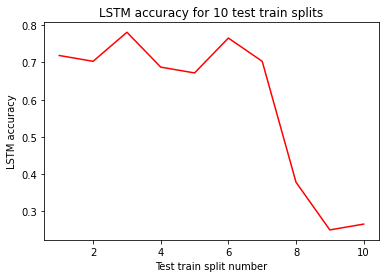

Peak LSTM classification accuracy:  0.78125


In [ ]:
#Plotting LSTM accuracy
x = np.arange(1, len(LSTM_accuracy1)+1)
y_new = []
for i in range(0,len(LSTM_accuracy1)):
  temp = LSTM_accuracy1[i].cpu()
  y_new.append(temp)
y = np.array(y_new)

# plotting
plt.title("LSTM accuracy for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("LSTM accuracy")
plt.plot(x, y, color ="red")
plt.show()

#printing max LSTM classification accuracy
print("Peak LSTM classification accuracy: ", np.amax(y))

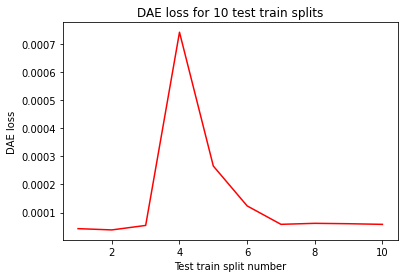

Min DAE loss:  3.854324e-05


In [ ]:
#Plotting DAE loss
x = np.arange(1, len(DAE_loss1)+1)
y_new = []
for i in range(0,len(DAE_loss1)):
  temp = DAE_loss1[i].cpu().detach()
  y_new.append(temp)
y = np.array(y_new)

# plotting
plt.title("DAE loss for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("DAE loss")
plt.plot(x, y, color ="red")
plt.show()

#printing min DAE loss
print("Min DAE loss: ", np.amin(y))

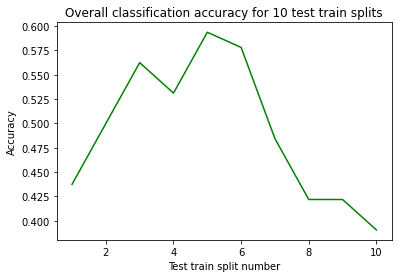

Peak classification accuracy:  0.59375


In [ ]:
#Plotting XGB/Overall network accuracy
x = np.arange(1, len(XGB_accuracy1)+1)
y = np.array(XGB_accuracy1)

# plotting
plt.title("Overall classification accuracy for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("Accuracy")
plt.plot(x, y, color ="green")
plt.show()

#printing max overall classification accuracy
print("Peak classification accuracy: ", np.amax(y))

# METHOD 2: LEAVE ONE SUBJECT OUT CROSS VALIDATION

In [ ]:
def get_X_y_subject_train(sub):
  subjects = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  subjects.remove(sub)
  X,y = get_X_y_sub(subjects[0])
  for i in range(1,13):
    X_sub, y_sub = get_X_y_sub(subjects[i])
    X = np.concatenate((X, X_sub), axis=0)
    y = np.concatenate((y, y_sub), axis=0)
  return X, y

Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  1
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2331999  =      0.000 ...  2331.999 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.8037, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5125, device='cuda:0')
For testing:
Batch loss

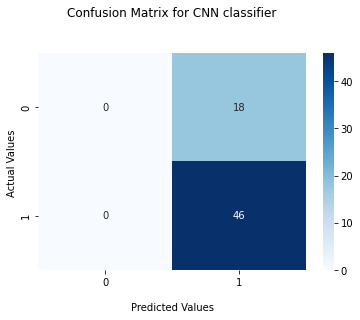

CNN F1 Score:  0.8363636363636363
LSTM
For training:
Batch loss:  tensor(0.6889, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5469, device='cuda:0')
For testing:
Batch loss:  tensor(0.6569, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.7188, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 18]
 [ 0 46]]


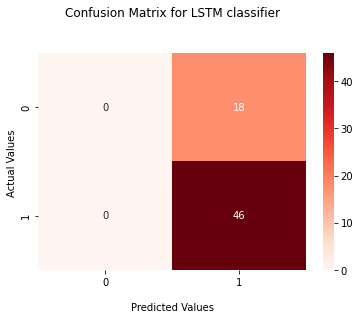

LSTM F1 Score:  0.8363636363636363
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.515625
OVERALL CONFUSION MATRIX
[[ 5 13]
 [18 28]]


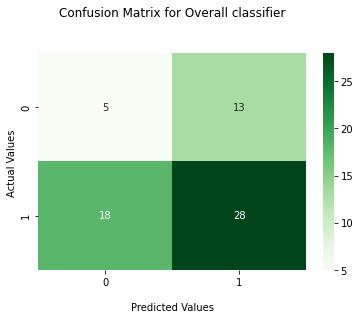

OVERALL F1 Score:  0.6436781609195402
Reading 0 ... 2331999  =      0.000 ...  2331.999 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6914, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5312, device='cuda:0')
For testing:
Batch loss

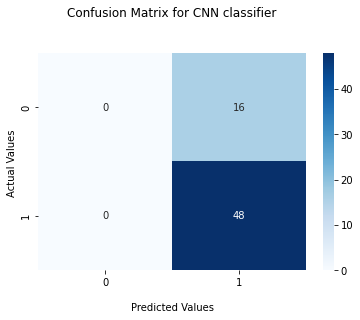

CNN F1 Score:  0.8571428571428571
LSTM
For training:
Batch loss:  tensor(0.6904, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5375, device='cuda:0')
For testing:
Batch loss:  tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.3000, device='cuda:0')
LSTM CONFUSION MATRIX
[[16  0]
 [48  0]]


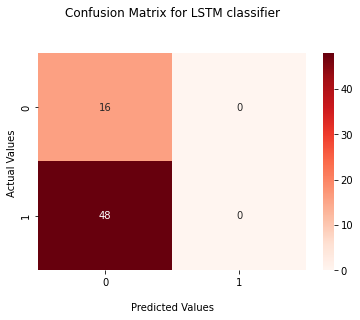

LSTM F1 Score:  0.0
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.296875
OVERALL CONFUSION MATRIX
[[10  6]
 [39  9]]


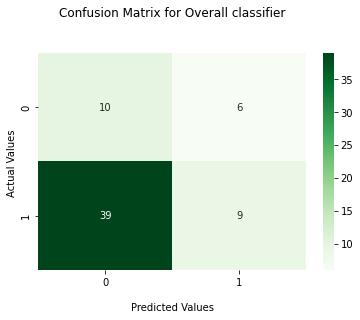

OVERALL F1 Score:  0.2857142857142857
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  3
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filter

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 2066799  =      0.000 ...  2066.799 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6886, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5469, device='cuda:0')
For testing:
Batch loss

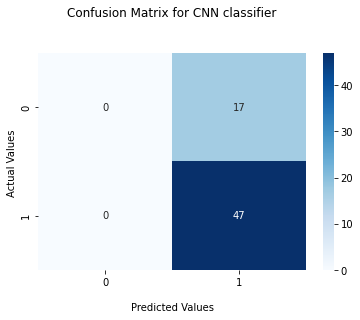

CNN F1 Score:  0.8468468468468469
LSTM
For training:
Batch loss:  tensor(0.6888, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5425, device='cuda:0')
For testing:
Batch loss:  tensor(0.6577, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.6594, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 17]
 [ 0 47]]


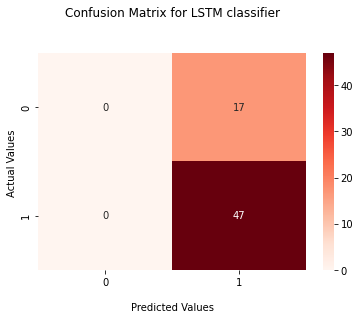

LSTM F1 Score:  0.8468468468468469
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.59375
OVERALL CONFUSION MATRIX
[[ 4 13]
 [13 34]]


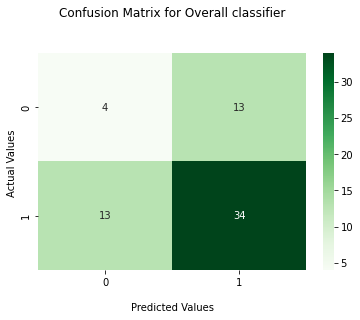

OVERALL F1 Score:  0.723404255319149
Reading 0 ... 2066799  =      0.000 ...  2066.799 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6758, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.6794, device='cuda:0')
For testing:
Batch loss

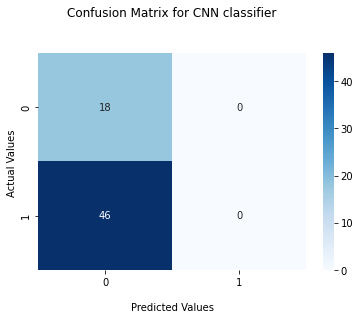

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6853, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5625, device='cuda:0')
For testing:
Batch loss:  tensor(0.6460, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.7188, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 18]
 [ 0 46]]


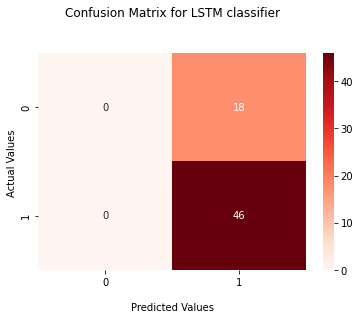

LSTM F1 Score:  0.8363636363636363
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.546875
OVERALL CONFUSION MATRIX
[[ 5 13]
 [16 30]]


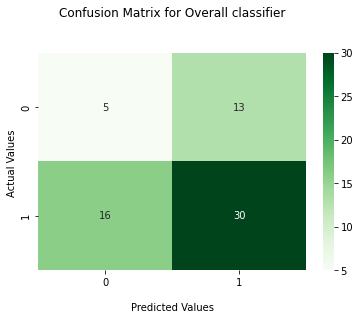

OVERALL F1 Score:  0.6741573033707865
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6888, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5469, device='cuda:0')
For testing:
Batch loss

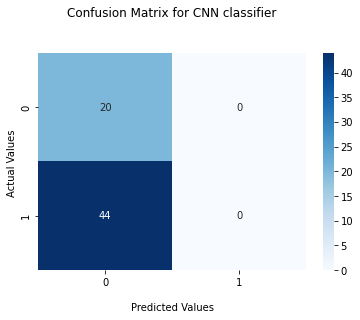

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6941, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5000, device='cuda:0')
For testing:
Batch loss:  tensor(0.6867, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5375, device='cuda:0')
LSTM CONFUSION MATRIX
[[20  0]
 [44  0]]


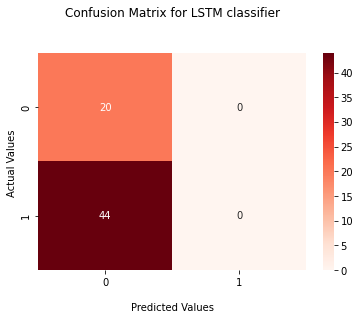

LSTM F1 Score:  0.0
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(1.6522e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(1.6734e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.546875
OVERALL CONFUSION MATRIX
[[11  9]
 [20 24]]


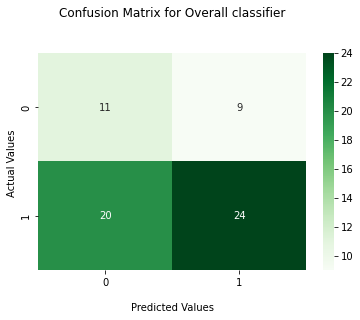

OVERALL F1 Score:  0.6233766233766234
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  6
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filter

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2049599  =      0.000 ...  2049.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.7003, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4844, device='cuda:0')
For testing:
Batch loss

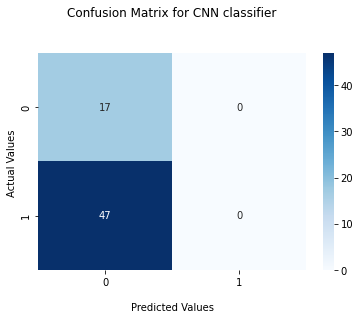

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6896, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5431, device='cuda:0')
For testing:
Batch loss:  tensor(0.6620, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.7156, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 17]
 [ 0 47]]


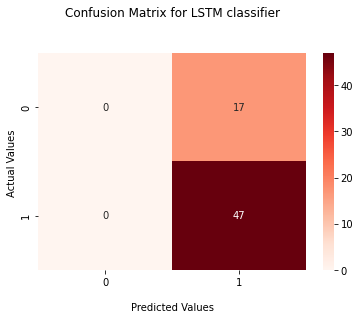

LSTM F1 Score:  0.8468468468468469
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(3.3285e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(3.3148e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.453125
OVERALL CONFUSION MATRIX
[[ 4 13]
 [22 25]]


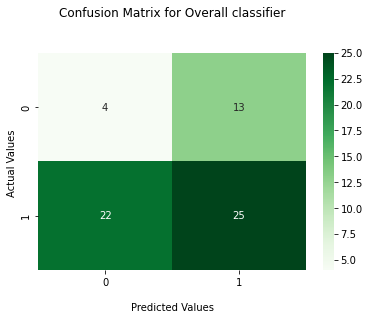

OVERALL F1 Score:  0.5882352941176471
Reading 0 ... 2049599  =      0.000 ...  2049.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  7
+-----------------------------------------------------+
Number of class 0:  25
Number of class 1:  60
Proportion of class 0:  0.29411764705882354
Proportion of class 1:  0.7058823529411765
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filte

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.7015, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4375, device='cuda:0')
For testing:
Batch loss

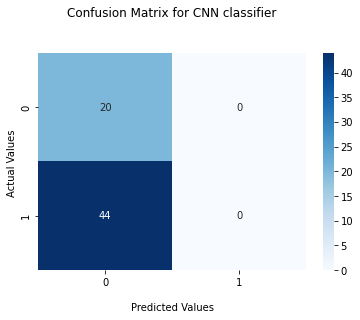

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6913, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5312, device='cuda:0')
For testing:
Batch loss:  tensor(0.6708, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.6875, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 20]
 [ 0 44]]


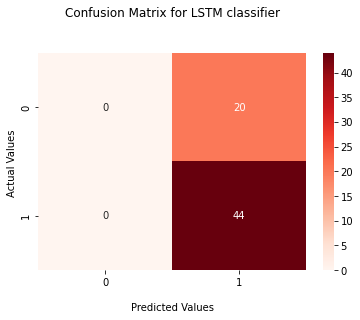

LSTM F1 Score:  0.8148148148148148
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(2.1682e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(2.1580e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.609375
OVERALL CONFUSION MATRIX
[[ 6 14]
 [11 33]]


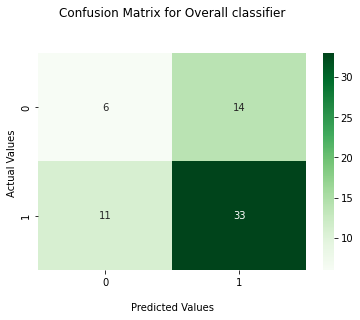

OVERALL F1 Score:  0.7252747252747254
Reading 0 ... 1965599  =      0.000 ...  1965.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6938, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4912, device='cuda:0')
For testing:
Batch loss

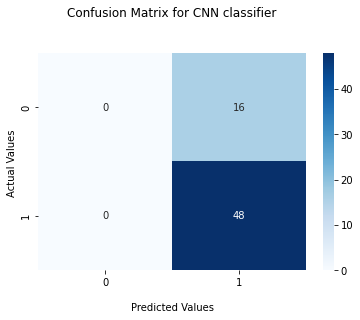

CNN F1 Score:  0.8571428571428571
LSTM
For training:
Batch loss:  tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5056, device='cuda:0')
For testing:
Batch loss:  tensor(0.6988, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4100, device='cuda:0')
LSTM CONFUSION MATRIX
[[16  0]
 [48  0]]


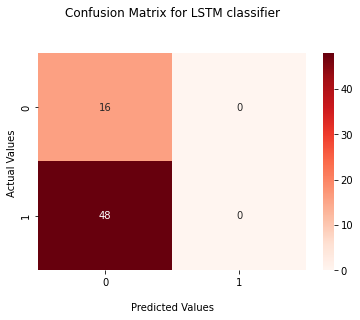

LSTM F1 Score:  0.0
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(1.3126e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(1.3421e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.4375
OVERALL CONFUSION MATRIX
[[ 4 12]
 [24 24]]


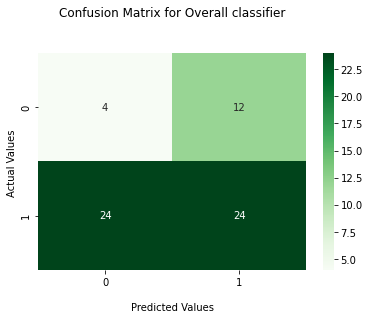

OVERALL F1 Score:  0.5714285714285715
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  9
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filter

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2096399  =      0.000 ...  2096.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6961, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4281, device='cuda:0')
For testing:
Batch loss

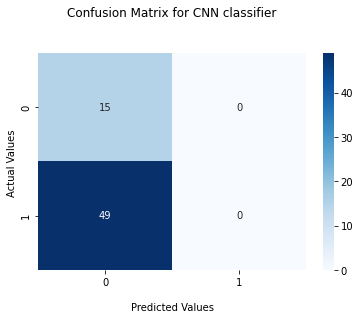

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6932, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5000, device='cuda:0')
For testing:
Batch loss:  tensor(0.6962, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4256, device='cuda:0')
LSTM CONFUSION MATRIX
[[15  0]
 [49  0]]


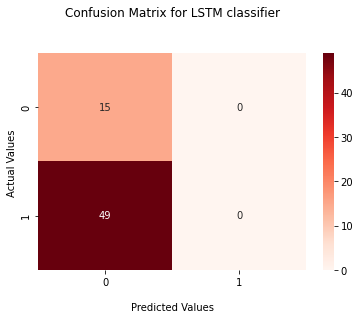

LSTM F1 Score:  0.0
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(9.3223e-06, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(9.2928e-06, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.59375
OVERALL CONFUSION MATRIX
[[ 7  8]
 [18 31]]


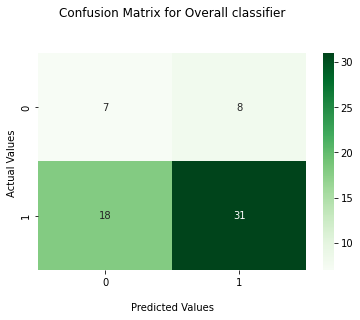

OVERALL F1 Score:  0.7045454545454547
Reading 0 ... 2096399  =      0.000 ...  2096.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  10
+-----------------------------------------------------+
Number of class 0:  25
Number of class 1:  60
Proportion of class 0:  0.29411764705882354
Proportion of class 1:  0.7058823529411765
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filt

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6910, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5625, device='cuda:0')
For testing:
Batch loss

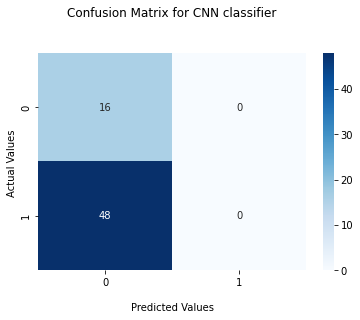

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6927, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5138, device='cuda:0')
For testing:
Batch loss:  tensor(0.6802, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.7200, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 16]
 [ 0 48]]


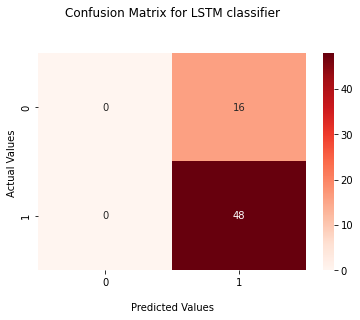

LSTM F1 Score:  0.8571428571428571
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(1.3142e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(1.3459e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.5625
OVERALL CONFUSION MATRIX
[[ 7  9]
 [19 29]]


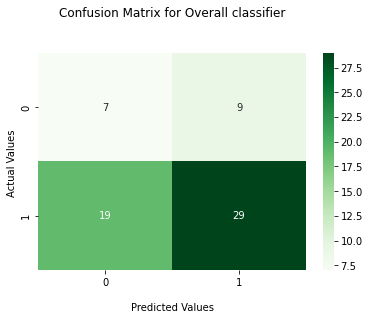

OVERALL F1 Score:  0.6744186046511628
Reading 0 ... 2401699  =      0.000 ...  2401.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter pa

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6885, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5625, device='cuda:0')
For testing:
Batch loss

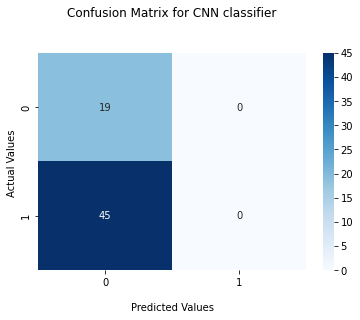

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6930, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5087, device='cuda:0')
For testing:
Batch loss:  tensor(0.7010, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.3862, device='cuda:0')
LSTM CONFUSION MATRIX
[[19  0]
 [45  0]]


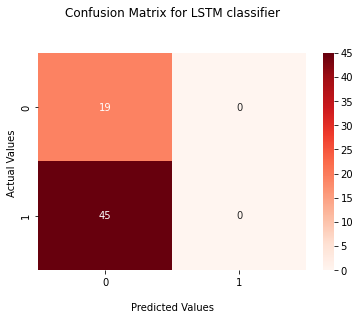

LSTM F1 Score:  0.0
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(9.2980e-06, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(9.2487e-06, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.421875
OVERALL CONFUSION MATRIX
[[ 8 11]
 [26 19]]


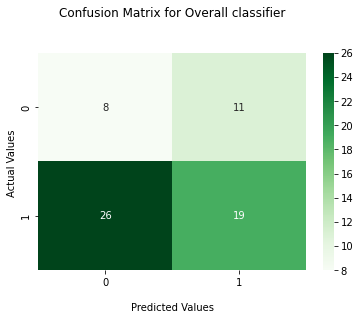

OVERALL F1 Score:  0.5066666666666666
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6995, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4375, device='cuda:0')
For testing:
Batch loss

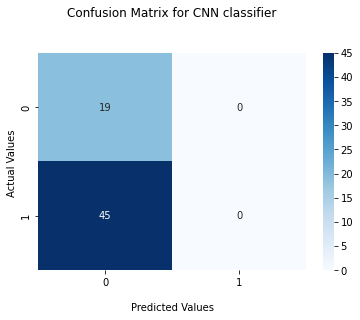

CNN F1 Score:  0.0
LSTM
For training:
Batch loss:  tensor(0.6891, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5469, device='cuda:0')
For testing:
Batch loss:  tensor(0.7287, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.2969, device='cuda:0')
LSTM CONFUSION MATRIX
[[19  0]
 [45  0]]


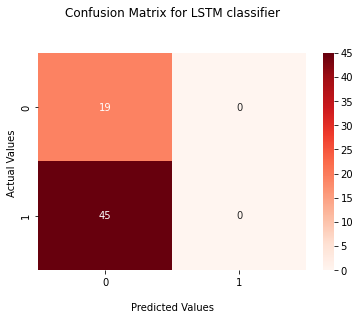

LSTM F1 Score:  0.0
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(2.6070e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(2.5998e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.46875
OVERALL CONFUSION MATRIX
[[12  7]
 [27 18]]


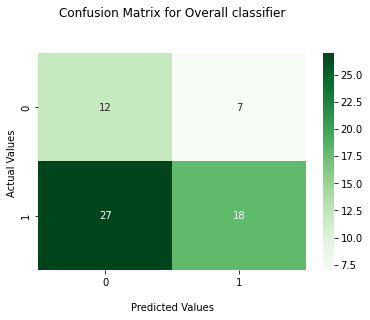

OVERALL F1 Score:  0.5142857142857142
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.4837, device='cuda:0')
For testing:
Batch loss

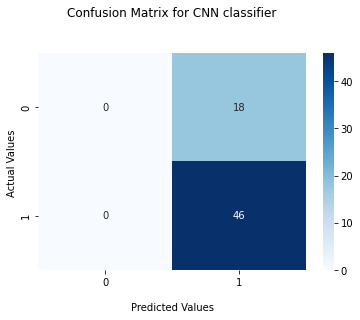

CNN F1 Score:  0.8363636363636363
LSTM
For training:
Batch loss:  tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5112, device='cuda:0')
For testing:
Batch loss:  tensor(0.6843, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5788, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 18]
 [ 0 46]]


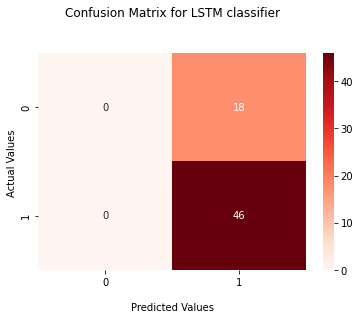

LSTM F1 Score:  0.8363636363636363
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(2.0503e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(2.0260e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.53125
OVERALL CONFUSION MATRIX
[[ 6 12]
 [18 28]]


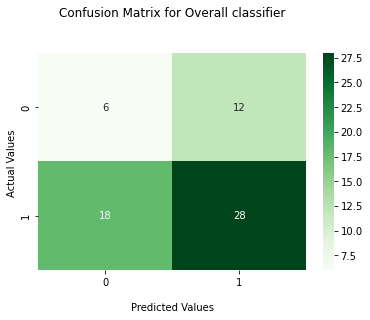

OVERALL F1 Score:  0.6511627906976744
Reading 0 ... 2757399  =      0.000 ...  2757.399 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  14
+-----------------------------------------------------+
Number of class 0:  30
Number of class 1:  75
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  2
+-----------------------------------------------------+
Number of class 0:  23
Number of class 1:  65
Proportion of class 0:  0.26136363636363635
Proportion of class 1:  0.7386363636363636
+-----------------------------------------------------+
Reading 0 ... 1904399  =      0.000 ...  1904.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  4
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2366699  =      0.000 ...  2366.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  5
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2090899  =      0.000 ...  2090.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter par

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  8
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
Reading 0 ... 2055199  =      0.000 ...  2055.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter para

<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  11
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  62
Proportion of class 0:  0.27906976744186046
Proportion of class 1:  0.7209302325581395
+-----------------------------------------------------+
Reading 0 ... 2133599  =      0.000 ...  2133.599 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  12
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  60
Proportion of class 0:  0.2857142857142857
Proportion of class 1:  0.7142857142857143
+-----------------------------------------------------+
Reading 0 ... 2072699  =      0.000 ...  2072.699 secs...


<ipython-input-5-6b43028484cc>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  rawEEG = mne.io.read_raw_cnt(fileName, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)

Printing trials info for sub  13
+-----------------------------------------------------+
Number of class 0:  24
Number of class 1:  61
Proportion of class 0:  0.2823529411764706
Proportion of class 1:  0.7176470588235294
+-----------------------------------------------------+
CNN
For training:
Batch loss:  tensor(0.6924, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5312, device='cuda:0')
For testing:
Batch loss

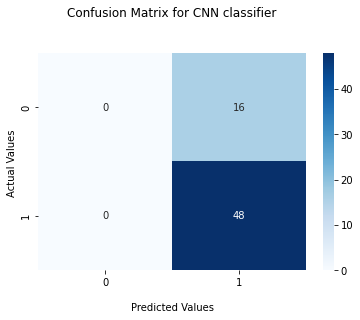

CNN F1 Score:  0.8571428571428571
LSTM
For training:
Batch loss:  tensor(0.6927, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.5156, device='cuda:0')
For testing:
Batch loss:  tensor(0.6767, device='cuda:0', grad_fn=<DivBackward0>) Batch accuracy:  tensor(0.7500, device='cuda:0')
LSTM CONFUSION MATRIX
[[ 0 16]
 [ 0 48]]


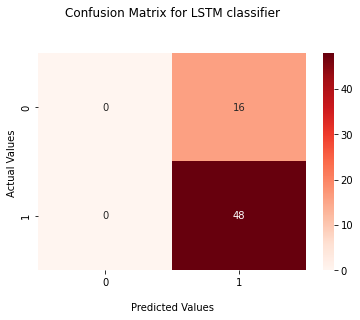

LSTM F1 Score:  0.8571428571428571
DAE
output size:  torch.Size([64, 1152])
For training:
Batch loss:  tensor(1.2244e-05, device='cuda:0', grad_fn=<DivBackward0>)
For testing:
Batch loss:  tensor(1.2233e-05, device='cuda:0', grad_fn=<DivBackward0>)
XGB
output size:  (64,)
For training:
Batch accuracy:  1.0
For testing:
Batch accuracy:  0.5625
OVERALL CONFUSION MATRIX
[[ 8  8]
 [20 28]]


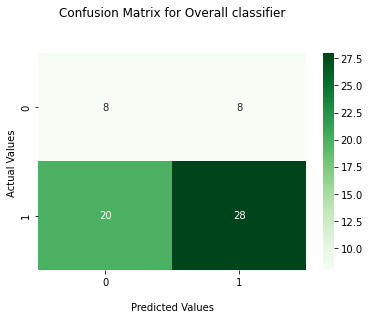

OVERALL F1 Score:  0.6666666666666666


In [ ]:
CNN_accuracy2=[]
LSTM_accuracy2=[]
DAE_loss2=[]
XGB_accuracy2=[]

for i in range(0,14):
    torch.cuda.empty_cache()
    X_test, y_test = get_X_y_sub(i)
    X_train, y_train = get_X_y_subject_train(i)

    #weighted random sampler to remove imbalance in  mini batch
    #print('y train tags 0/1: {}/{}'.format(len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))
    class_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weight = 1. / class_count
    samples_weight=[]
    for t in y_train:
        if t==0:
            samples_weight.append(weight[0])
        else:
            samples_weight.append(weight[1])
    samples_weight = np.array(samples_weight)
    samples_weight=torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    #creating a custom torch Dataset with training and test arrays
    #using dataloader for test data and train data
    training_data = MyDataset(X_train, y_train)
    training_dataloader = DataLoader(training_data, batch_size=64, sampler=sampler)
    test_data = MyDataset(X_test, y_test)
    test_dataloader = DataLoader(test_data, batch_size=64)

    #getting dataloader inputs ready for CNN network
    train_features, train_labels = next(iter(training_dataloader))
    #test_features, test_labels = next(iter(test_dataloader))
    train_X_CNN = train_features.reshape(64, 1, 62, 62)
    train_X_CNN = train_X_CNN.float()
    test_X_CNN = test_features.reshape(64, 1, 62, 62)
    test_X_CNN = test_X_CNN.float()
    train_y = train_labels.long()
    test_y = test_labels.long()
    #print("class 0 train: ", sum(train_y==0)/len(train_y), "class 1 train: ", sum(train_y==1)/len(train_y))
    #print("class 0 test: ", sum(test_y==0)/len(test_y), "class 1 test: ", sum(test_y==1)/len(test_y))
    CNN_batch_accuracy, CNN_batch_cm, CNN_batch_f1, CNN_train_out, CNN_test_out = model_fit_CNN()
    CNN_accuracy2.append(CNN_batch_accuracy)
    print("CNN CONFUSION MATRIX")
    print(CNN_batch_cm)
    ax = sb.heatmap(CNN_batch_cm, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix for CNN classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show()
    print("CNN F1 Score: ", CNN_batch_f1)

    torch.cuda.empty_cache()
    #getting dataloader inputs ready for LSTM network
    train_features, train_labels = next(iter(training_dataloader))
    test_features, test_labels = next(iter(test_dataloader))
    train_X_LSTM = train_features.reshape([64, 1, 62*62])
    train_X_LSTM = train_X_LSTM.float()
    test_X_LSTM = test_features.reshape([64, 1, 62*62])
    test_X_LSTM = test_X_LSTM.float()
    train_y = train_labels.long()
    test_y = test_labels.long()
    LSTM_batch_accuracy, LSTM_batch_cm, LSTM_batch_f1, LSTM_train_out, LSTM_test_out = model_fit_LSTM()
    LSTM_accuracy2.append(LSTM_batch_accuracy)
    print("LSTM CONFUSION MATRIX")
    print(LSTM_batch_cm)
    ax = sb.heatmap(LSTM_batch_cm, annot=True, cmap='Reds')
    ax.set_title('Confusion Matrix for LSTM classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show()
    print("LSTM F1 Score: ", LSTM_batch_f1)

    torch.cuda.empty_cache()
    #getting inputs ready for the DAE
    LSTM_train_out_reshaped = LSTM_train_out.reshape(LSTM_train_out.shape[0], LSTM_train_out.shape[2])
    LSTM_test_out_reshaped = LSTM_test_out.reshape(LSTM_test_out.shape[0], LSTM_test_out.shape[2])
    DAE_train = torch.cat((CNN_train_out, LSTM_train_out_reshaped), 1)
    DAE_test = torch.cat((CNN_test_out, LSTM_test_out_reshaped), 1)
    DAE_batch_loss_train, DAE_batch_loss_test, DAE_train_out, DAE_test_out = model_fit_DAE()
    DAE_loss2.append(DAE_batch_loss_test)

    torch.cuda.empty_cache()
    #getting inputs ready for the XGBoost layer
    XGB_train_X = DAE_train_out.cpu().detach().numpy()
    XGB_train_y = train_y.cpu().detach().numpy()
    XGB_test_X = DAE_test_out.cpu().detach().numpy()
    XGB_test_y = test_y.cpu().detach().numpy()
    XGB_train_out, XGB_test_out, XGB_batch_accuracy, XGB_batch_cm, XGB_batch_f1 = trainXGB()
    XGB_accuracy2.append(XGB_batch_accuracy)
    print("OVERALL CONFUSION MATRIX")
    print(XGB_batch_cm)
    ax = sb.heatmap(XGB_batch_cm, annot=True, cmap='Greens')
    ax.set_title('Confusion Matrix for Overall classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show()
    print("OVERALL F1 Score: ", XGB_batch_f1)

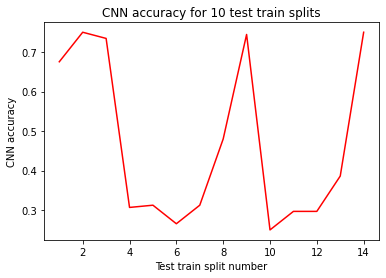

Peak CNN classification accuracy:  0.75


In [ ]:
#Plotting CNN accuracy
x = np.arange(1, len(CNN_accuracy2)+1)
y_new = []
for i in range(0,len(CNN_accuracy2)):
  temp = CNN_accuracy2[i].cpu()
  y_new.append(temp)
y = np.array(y_new)

# plotting
plt.title("CNN accuracy for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("CNN accuracy")
plt.plot(x, y, color ="red")
plt.show()

#printing max CNN classification accuracy
print("Peak CNN classification accuracy: ", np.amax(y))

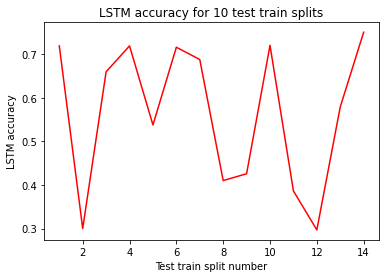

Peak LSTM classification accuracy:  0.75


In [ ]:
#Plotting LSTM accuracy
x = np.arange(1, len(LSTM_accuracy2)+1)
y_new = []
for i in range(0,len(LSTM_accuracy2)):
  temp = LSTM_accuracy2[i].cpu()
  y_new.append(temp)
y = np.array(y_new)

# plotting
plt.title("LSTM accuracy for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("LSTM accuracy")
plt.plot(x, y, color ="red")
plt.show()

#printing max LSTM classification accuracy
print("Peak LSTM classification accuracy: ", np.amax(y))

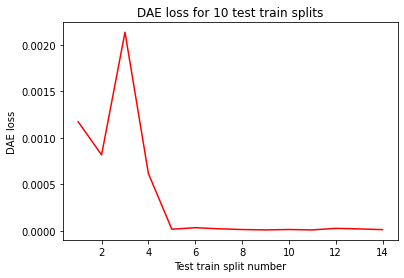

Min DAE loss:  9.248665e-06


In [ ]:
#Plotting DAE loss
x = np.arange(1, len(DAE_loss2)+1)
y_new = []
for i in range(0,len(DAE_loss2)):
  temp = DAE_loss2[i].cpu().detach()
  y_new.append(temp)
y = np.array(y_new)

# plotting
plt.title("DAE loss for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("DAE loss")
plt.plot(x, y, color ="red")
plt.show()

#printing max CNN classification accuracy
print("Min DAE loss: ", np.amin(y))

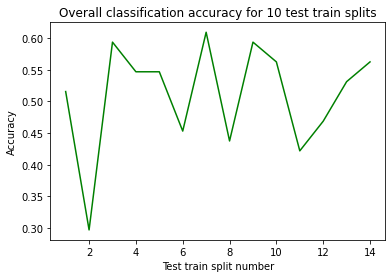

Peak classification accuracy:  0.609375


In [ ]:
#Plotting XGB/Overall network accuracy
x = np.arange(1, len(XGB_accuracy2)+1)
y = np.array(XGB_accuracy2)

# plotting
plt.title("Overall classification accuracy for 10 test train splits")
plt.xlabel("Test train split number")
plt.ylabel("Accuracy")
plt.plot(x, y, color ="green")
plt.show()

#printing max overall classification accuracy
print("Peak classification accuracy: ", np.amax(y))